### Download and compute data

Launch this next code line, if you didn't download data yet

In [128]:
!python utils/dataHandler.py
!python utils/datasetHandler.py


Annual Volatility :
USO     0.376264
URTH    0.169925
GLD     0.145484
dtype: float64
/Users/hugo/Documents/Finance/projet/OptiFolio/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/Users/hugo/Documents/Finance/projet/OptiFolio/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [129]:
from env import OptiFolioEnv

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

import torch

In [ ]:
dataset_path = "data/dataset/dataset.csv"
dataset_return_path = "data/returns/data_returns.csv"
df = pd.read_csv(dataset_path, index_col="Date")
return_df = pd.read_csv(dataset_return_path, index_col="Date")

train_df, test_df = train_test_split(df,test_size=0.9, shuffle=False)

train_df.to_csv("data/dataset/train/train.csv")
test_df.to_csv("data/dataset/train/test.csv")

/Users/hugo/Documents/Finance/projet/OptiFolio/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [131]:
class PPOActorCritic(nn.Module):
    def __init__(self, input_shape, action_dim):
        super().__init__()

        self.input_dim = input_shape[0] * input_shape[1]
        self.action_dim = action_dim

        self.shared = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )

        self.actor_alpha = nn.Sequential(
            nn.Linear(256, action_dim),
            nn.Softplus()  
        )

        self.critic = nn.Linear(256, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.constant_(m.bias, 0)

        nn.init.orthogonal_(self.actor_alpha[0].weight, gain=0.01)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)

        x = x.reshape(x.size(0), -1)
        features = self.shared(x)

        alpha = self.actor_alpha(features) + 1e-6
        value = self.critic(features)

        return alpha, value

    def get_action(self, x):
        alpha, value = self.forward(x)
        dist = Dirichlet(alpha)

        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action, log_prob, value

    def evaluate_actions(self, x, actions):
        alpha, value = self.forward(x)
        dist = Dirichlet(alpha)

        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()

        return log_probs, entropy, value

In [230]:
train_env = OptiFolioEnv(dataframe=train_df, return_data=return_df, initial_amount=1000, lookback=62)
test_env = OptiFolioEnv(dataframe=test_df, return_data=return_df, initial_amount=1000, lookback=62)

m_train_env = Monitor(train_env)
m_test_env = Monitor(test_env)

model = PPO(
    policy="MlpPolicy", 
    env=m_train_env,
    learning_rate=1e-4,
    n_steps=2048,           
    batch_size=64,          
    gamma=0.99,             
    verbose=0,
    tensorboard_log="./ppo_trading_logs/"
)



print("Test du modèle...")
model.load("model/ppo_optifolio_v1")
obs, info = m_test_env.reset()
done = False
history_portfolio = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    weights = action / (np.sum(action) + 1e-8) 
    
    obs, reward, terminated, truncated, info = m_test_env.step(weights)
    history_portfolio.append(info['portfolio_value'])
    done = terminated or truncated

print(f"Valeur finale du portefeuille : {info['portfolio_value']:.2f}")

Test du modèle...

ValueError: Error: Unexpected observation shape (1, 96) for Box environment, please use (62, 96) or (n_env, 62, 96) for the observation shape.

In [227]:

aligned_index = test_df.index[-len(history_portfolio):]

df = pd.DataFrame(history_portfolio, index=aligned_index, columns=['Valeur Portefeuille']).to_csv("model/results/Portfolio_evo.csv")

/Users/hugo/Documents/Finance/projet/OptiFolio/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

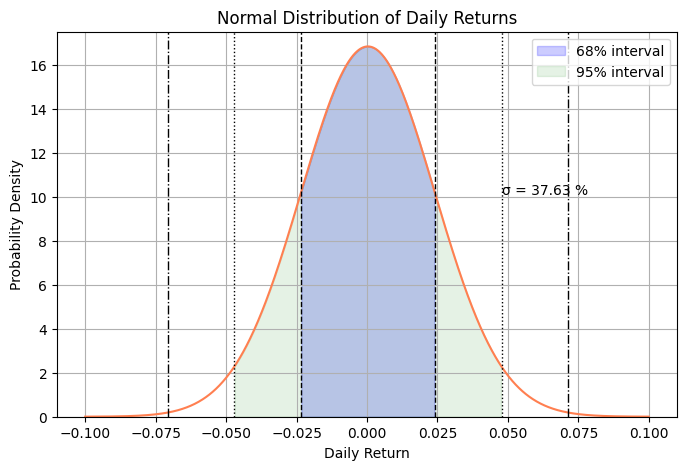

In [137]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd

returnssss = pd.read_csv("data/returns/data_returns.csv", index_col="Date")
volatility = pd.read_csv("data/volatility/data_volatility.csv")

return_mean = returnssss.mean()
mean = return_mean["USO"]
std = volatility["0"][0]

x = np.linspace(-0.1, 0.1, 1000)
y = scipy.stats.norm.pdf(x, mean, std/np.sqrt(252))

plt.figure(figsize=(8,5))
plt.plot(x, y, color='coral')

for i, style in zip([1, 2, 3], ['--', ':', '-.']):
    plt.axvline(mean + i*std/np.sqrt(252), linestyle=style, color='black', linewidth=1)
    plt.axvline(mean - i*std/np.sqrt(252), linestyle=style, color='black', linewidth=1)

plt.fill_between(x, 0, y, where=(x >= mean - std/np.sqrt(252)) & (x <= mean + std/np.sqrt(252)),
                 color='blue', alpha=0.2, label='68% interval')

plt.fill_between(x, 0, y, where=(x >= mean - 2*std/np.sqrt(252)) & (x <= mean + 2*std/np.sqrt(252)),
                 color='green', alpha=0.1, label='95% interval')

plt.text(mean + 2*std/np.sqrt(252), max(y)*0.6, f'σ = {std*100:.2f} %', rotation=0)

plt.grid(True)
plt.ylim(-0.001,17.5)
plt.title('Normal Distribution of Daily Returns', fontsize=12)
plt.xlabel('Daily Return')
plt.ylabel('Probability Density')
plt.legend()

plt.savefig("normal_distribution.png", dpi=300)
plt.show()
